In [1]:
import os
os.chdir('/Users/rv/Projects/7CS074') # Change to the project root directory

import pandas as pd

import global_vars 

from sklearn.model_selection import train_test_split

from evaluation import select_best_model_cv
from features import engineer_features
from models import get_type_models

In [2]:
# First we will check and run the preprocessing script
# In case this is already done, this will not overwrite existing files
from preprocessing import process_raw_multiple_data_files

process_raw_multiple_data_files()

In [3]:
import numpy as np

if not os.path.exists(global_vars.DATASET_CLEAN_FILE_PATH):
    raise FileNotFoundError(f"Dataset not found at {global_vars.DATASET_CLEAN_FILE_PATH}. Please ensure the dataset is placed correctly.")

df = pd.read_csv(global_vars.DATASET_CLEAN_FILE_PATH, sep=',', engine='python') # read with proper delimiter handling, and with python engine always
if df.empty:
    raise ValueError("Loaded dataset is empty. Please check the dataset file.")

print(f"Data loaded successfully from {global_vars.DATASET_CLEAN_FILE_PATH}.")

target_col_class = 'price_category'

min_samples_per_make=300
cv_splits=5

trained_models_per_make = {}

df_classification = df.copy()
df_classification['price_category'] = pd.cut(
    df_classification['price'],
    bins=[0, 10000, 20000, 30000, np.inf],
    labels=['Budget', 'Mid-Range', 'Premium', 'Luxury']
)

# Remove rows with NaN price_category
df_classification = df_classification.dropna(subset=['price_category'])

Data loaded successfully from /Users/rv/Projects/7CS074/data/clean/cleaned_dataset.csv.


In [ ]:
candidate_models = get_type_models('classification')

X_global = engineer_features(
    df_classification,
    global_vars.LOW_CATEGORICAL_FEATURES_OVERALL,
    global_vars.HIGH_CATEGORICAL_FEATURES_GLOBAL
)
Y_global = df_classification[target_col_class]

global_X_train, global_X_test, global_y_train, global_y_test = train_test_split(
    X_global, Y_global, test_size=0.2, random_state=42, stratify=Y_global
)

global_best_name_model, global_best_model, global_cv_scores = select_best_model_cv(
    global_X_train, global_y_train, candidate_models, cv_splits=cv_splits, scoring='f1_weighted'
)

global_predictions = global_best_model.predict(global_X_test)
global_feature_names = global_X_train.columns

In [ ]:
# Per-make models
# If the length of each dataframe of group is lower than the minimum sample variable, we shall pass and not create a 'per-make' model
# This is to make sure that algorithms like 'Random Forrest' gets trained on larger sets of data, as indented, if the condition is true, the make would fallback into the global model above.
for make, group_df in df.groupby("make"):
	if len(group_df) < min_samples_per_make:
		continue

	# Prepare features for classification
	X = engineer_features(
		df_classification,
		global_vars.LOW_CATEGORICAL_FEATURES_OVERALL,
  		global_vars.HIGH_CATEGORICAL_FEATURES_PER_MAKE
	)
	Y = df_classification[target_col_class]

	X_train, X_test, y_train, y_test = train_test_split(
		X, Y, test_size=0.2, random_state=42, stratify=Y
	)

	best_name, best_model, cv_scores = select_best_model_cv(
		X_train, y_train, candidate_models, cv_splits=cv_splits, scoring='f1_weighted'
	)

	predictions = best_model.predict(X_test)

	trained_models_per_make[make] = {
		"best_model_name": best_name,
		"model": best_model,
		"feature_names": X_train.columns,
		"X_test": X_test,
		"y_test": y_test,
		"predictions": predictions,
	}

In [6]:
from evaluation import classification_metrics

global_metrics = classification_metrics(y_test, global_predictions)

In [7]:
from evaluation import get_classification_report

print(f"\n Overall Dataset:")
print(f"  Best Model: {global_best_name_model}")
print(f"  Accuracy: {global_metrics['accuracy']:.3f}")
print(f"  Precision: {global_metrics['precision']:.3f}")
print(f"  Recall: {global_metrics['recall']:.3f}")
print(f"  F1-Score: {global_metrics['f1_score']:.3f}")

print(get_classification_report(
	y_test, 
	global_predictions, 
	target_names=['Budget', 'Mid-Range', 'Premium', 'Luxury']
))

for make_vehicle, data in trained_models_per_make.items():
	y_test = data['y_test']
	predictions = data['predictions']
	metrics = classification_metrics(y_test, predictions)

	print(f"\n{make_vehicle}:")
	print(f"  Best Model: {data['best_model_name']}")
	print(f"  Accuracy: {metrics['accuracy']:.3f}")
	print(f"  Precision: {metrics['precision']:.3f}")
	print(f"  Recall: {metrics['recall']:.3f}")
	print(f"  F1-Score: {metrics['f1_score']:.3f}")
 
	print(get_classification_report(
		y_test, 
		predictions, 
		target_names=['Budget', 'Mid-Range', 'Premium', 'Luxury']
	))


 Overall Dataset:
  Best Model: decision_tree
  Accuracy: 0.842
  Precision: 0.842
  Recall: 0.842
  F1-Score: 0.842
              precision    recall  f1-score   support

      Budget       0.85      0.86      0.86       892
   Mid-Range       0.77      0.77      0.77       790
     Premium       0.89      0.88      0.88      3088
      Luxury       0.80      0.81      0.80      2083

    accuracy                           0.84      6853
   macro avg       0.83      0.83      0.83      6853
weighted avg       0.84      0.84      0.84      6853


audi:
  Best Model: decision_tree
  Accuracy: 0.842
  Precision: 0.842
  Recall: 0.842
  F1-Score: 0.842
              precision    recall  f1-score   support

      Budget       0.85      0.86      0.86       892
   Mid-Range       0.77      0.77      0.77       790
     Premium       0.89      0.88      0.88      3088
      Luxury       0.80      0.81      0.80      2083

    accuracy                           0.84      6853
   macro avg   

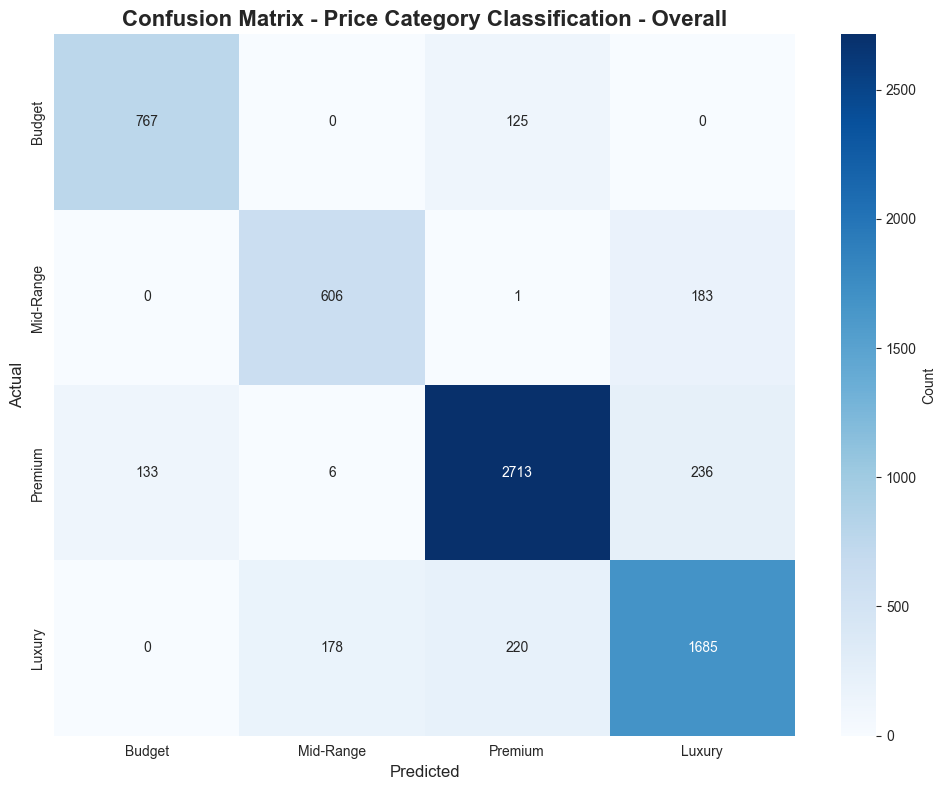

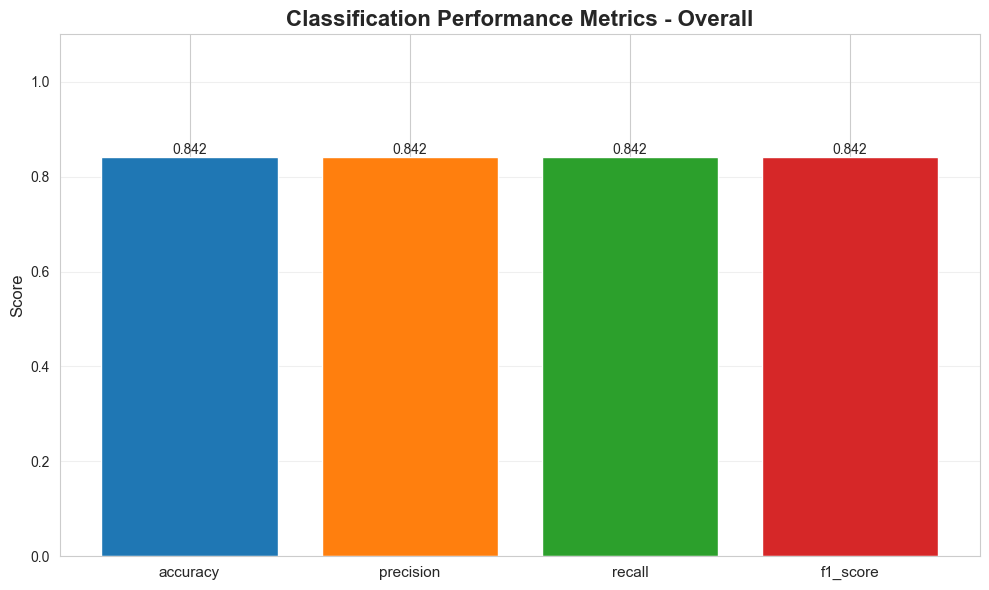

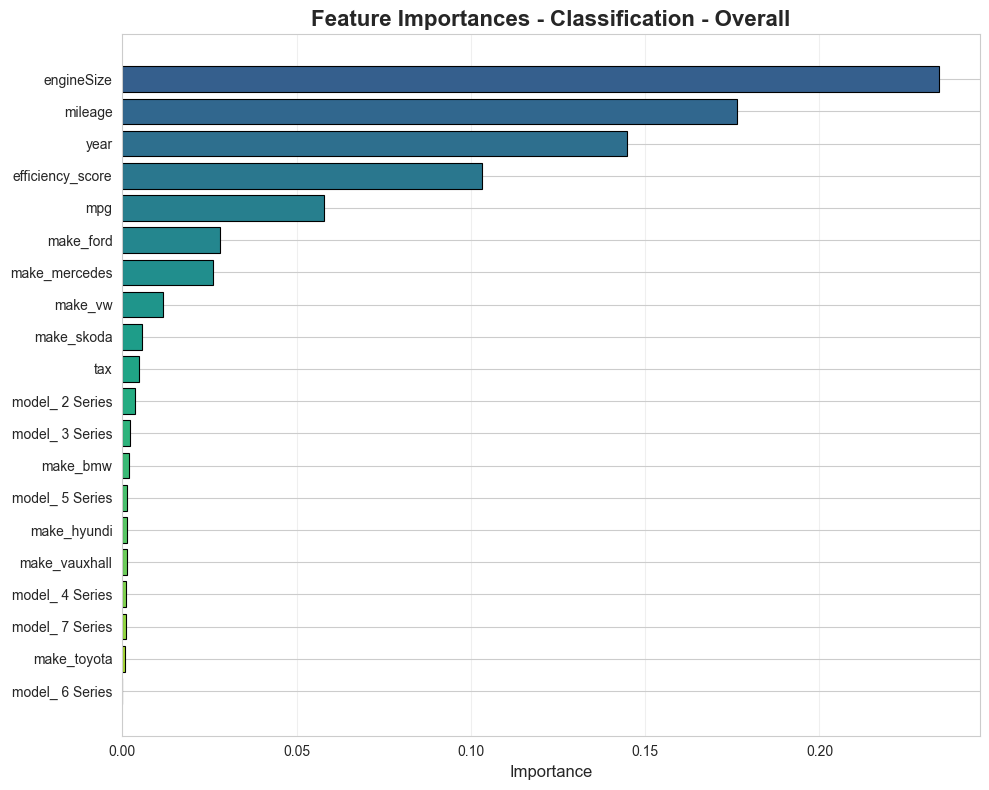

In [8]:
from features import get_feature_effects
from visualisation import plot_classification_metrics, plot_confusion_matrix, plot_feature_importances

plot_confusion_matrix(
	global_y_test, 
	global_predictions,
	labels=['Budget', 'Mid-Range', 'Premium', 'Luxury'],
	title=f"Confusion Matrix - Price Category Classification - Overall"
)

# Classification metrics bar chart
plot_classification_metrics(
	global_metrics,
	title=f"Classification Performance Metrics - Overall"
)

# Feature importances for classification
values_class, kind_class = get_feature_effects(global_best_model)
plot_feature_importances(
	values_class[:20],
	global_feature_names[:20],
	f"Feature {kind_class.title()}s - Classification - Overall"
)

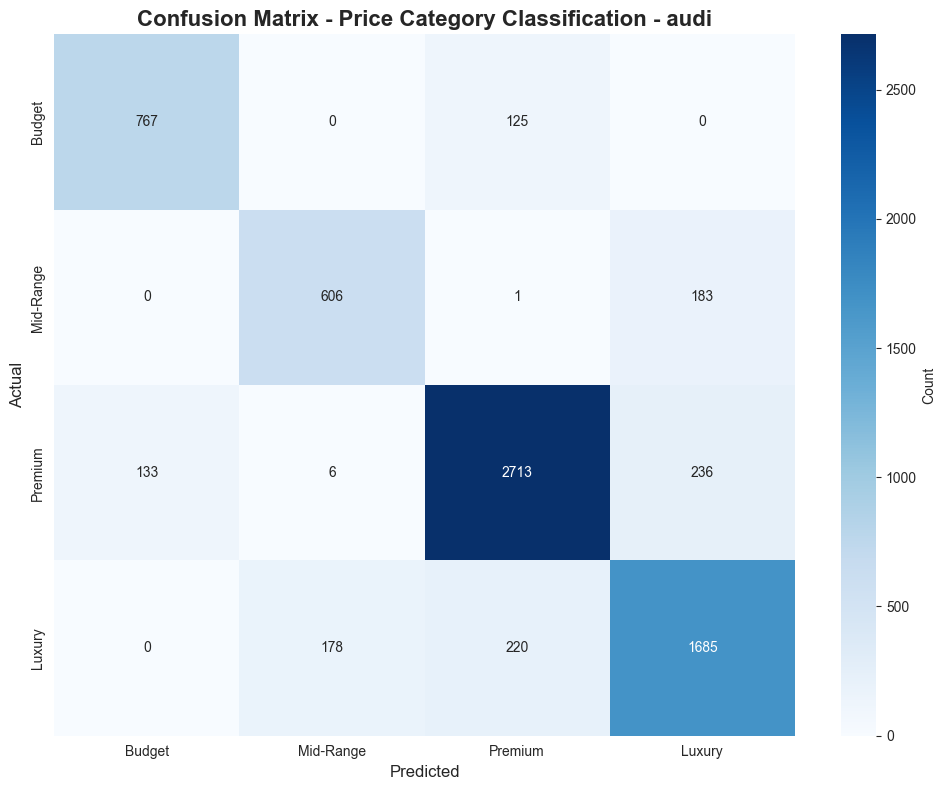

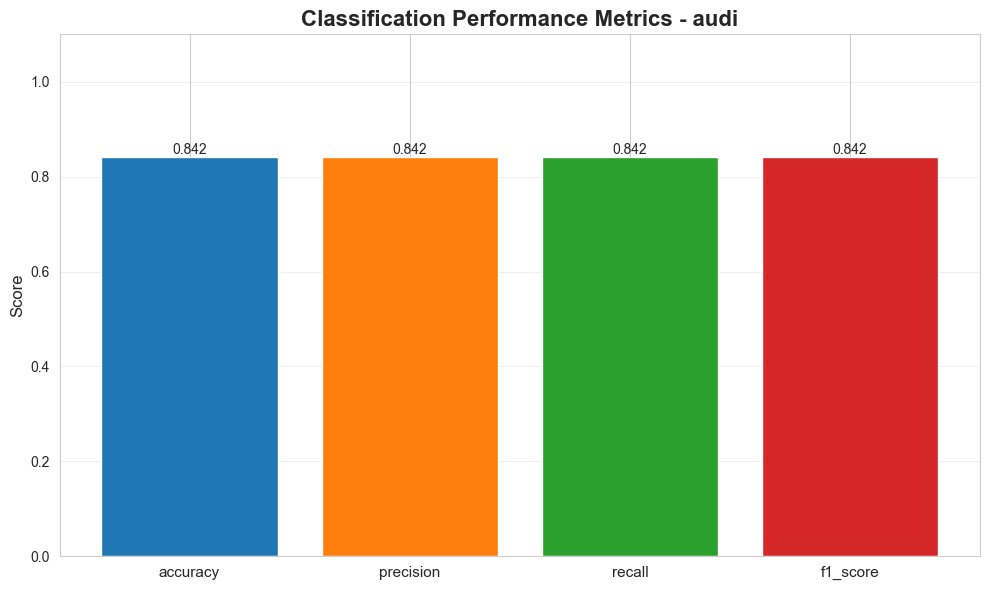

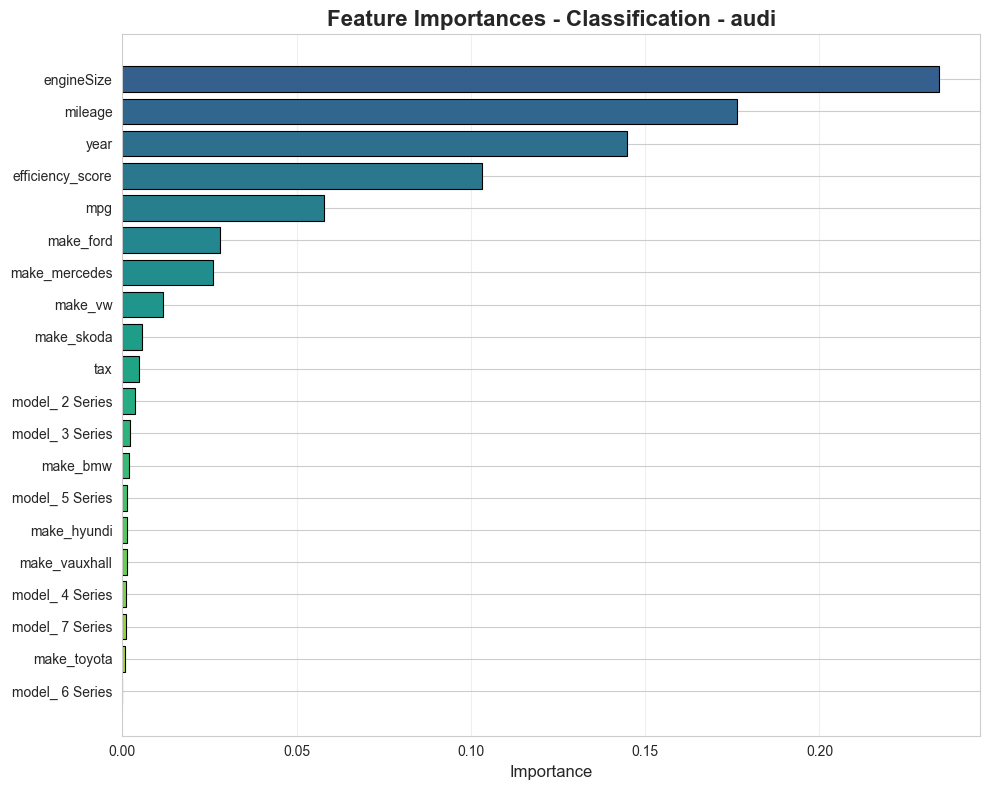

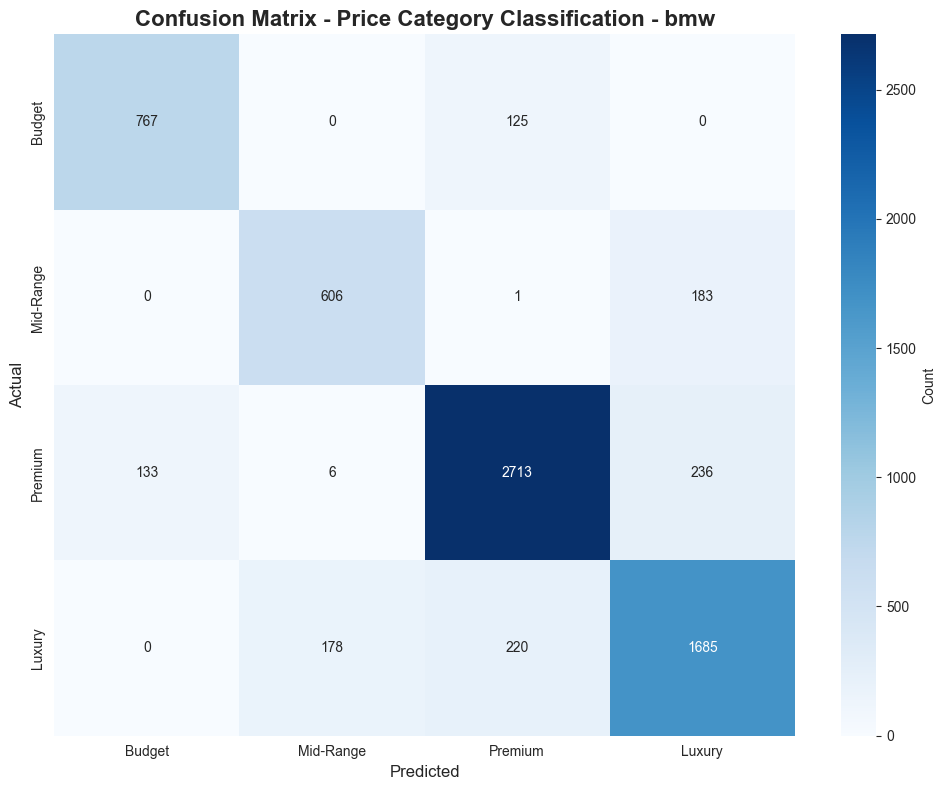

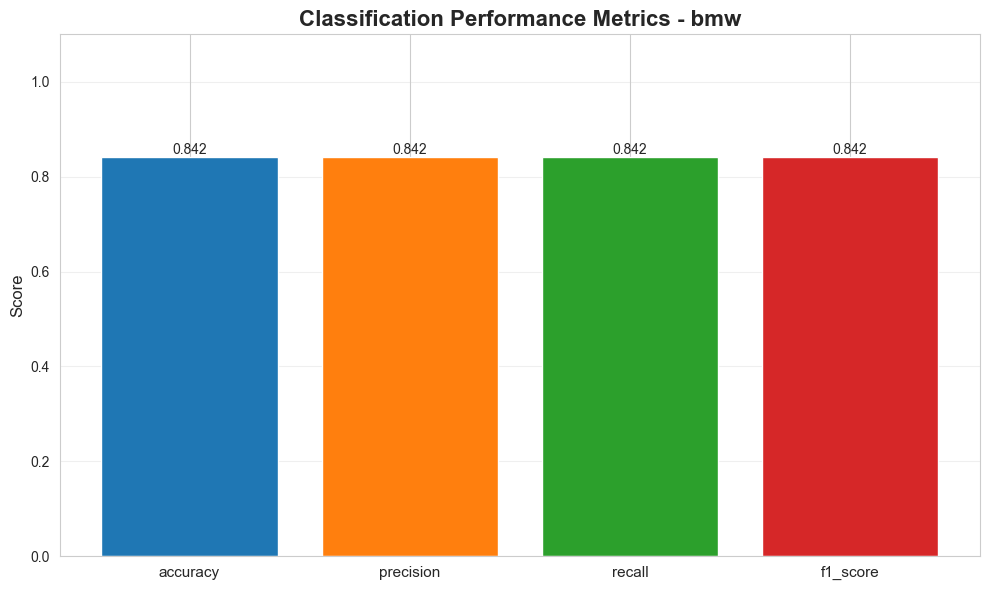

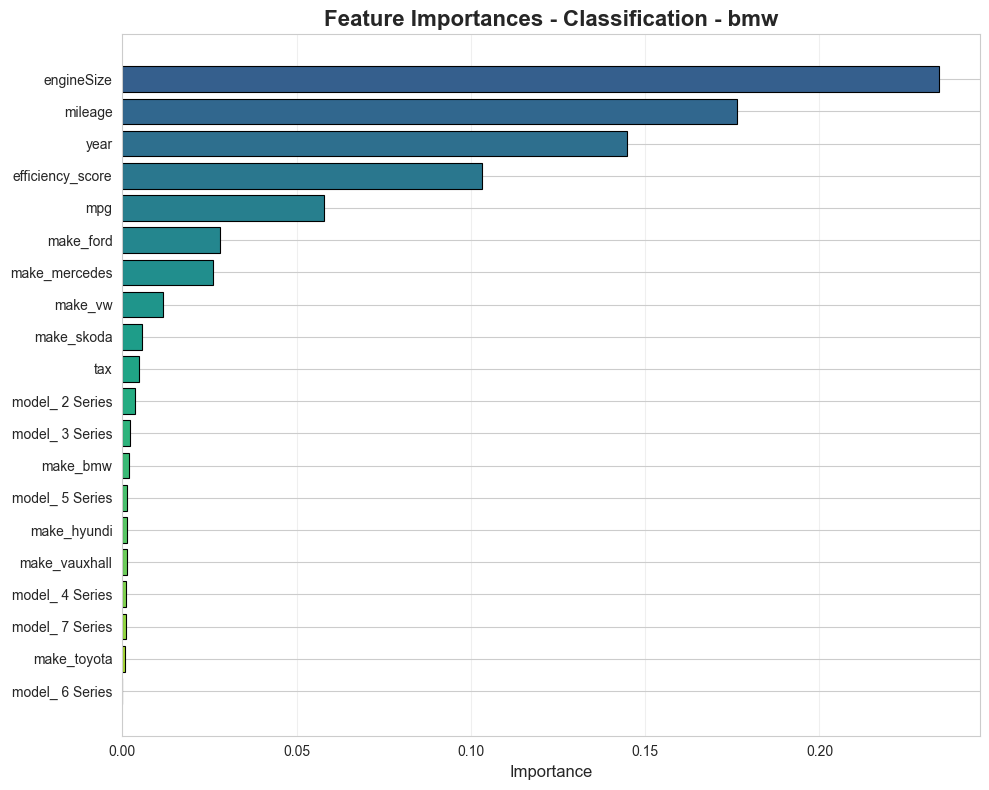

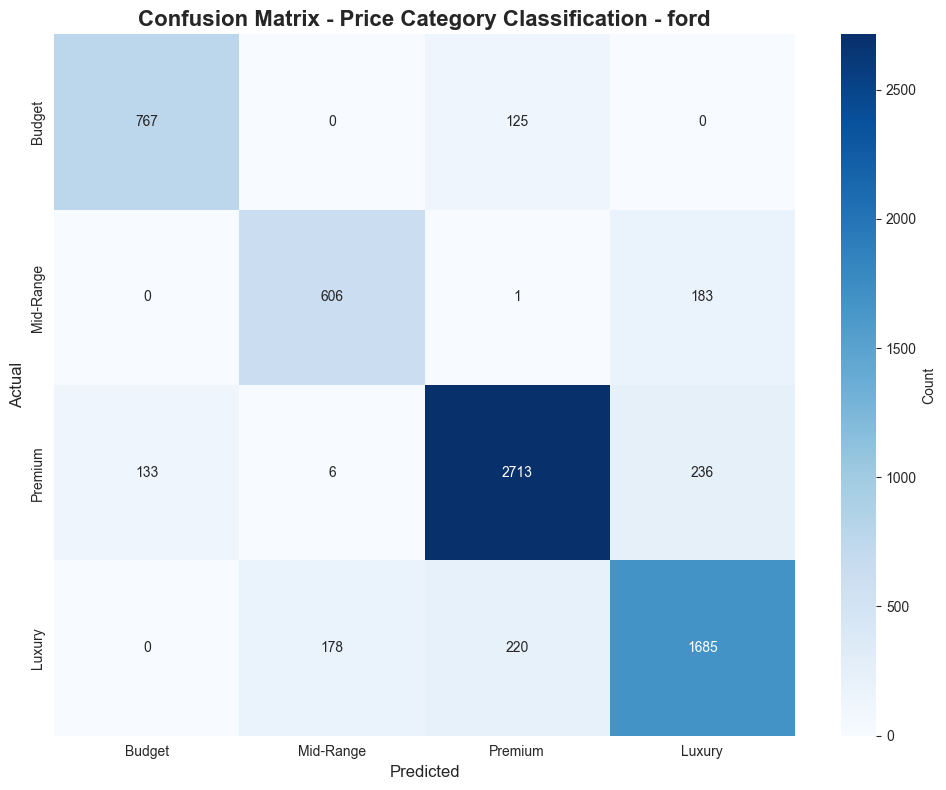

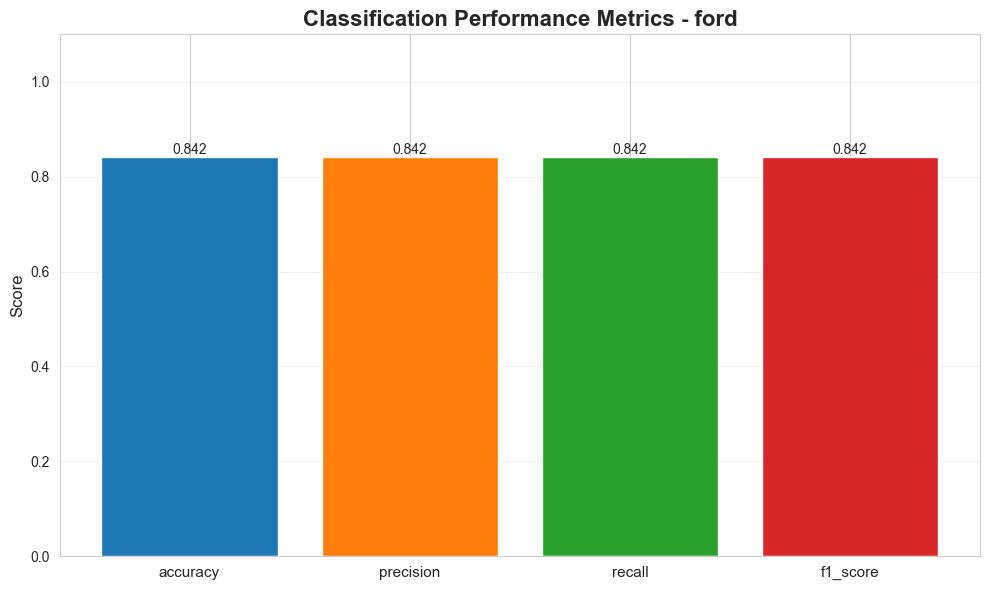

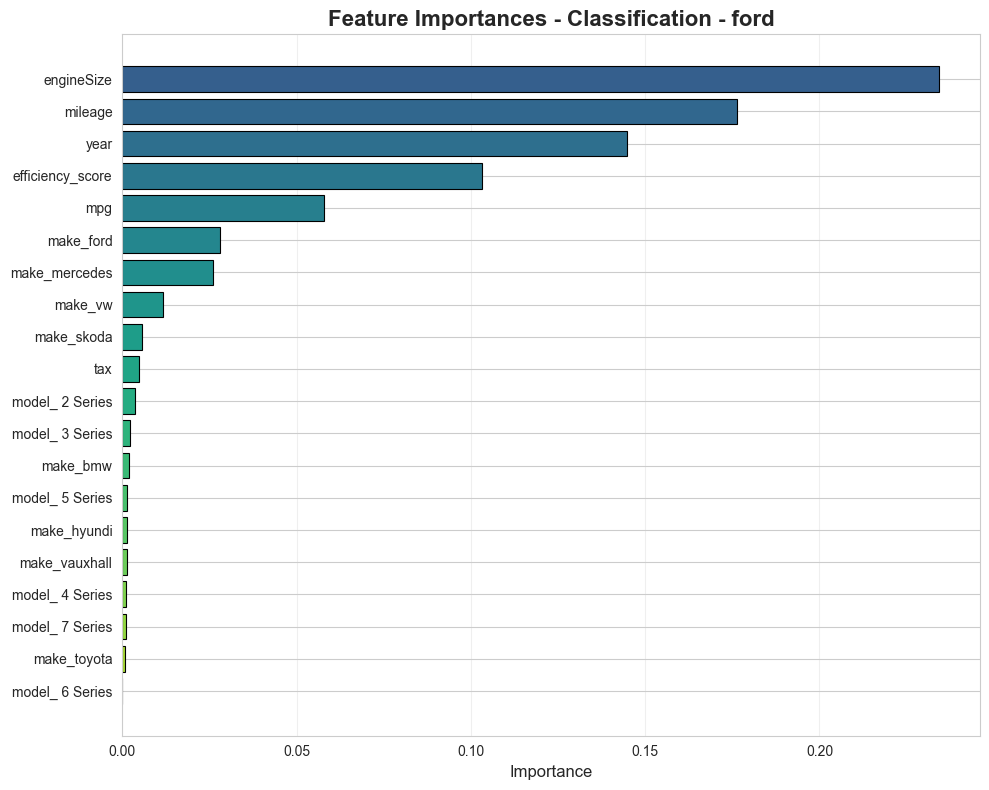

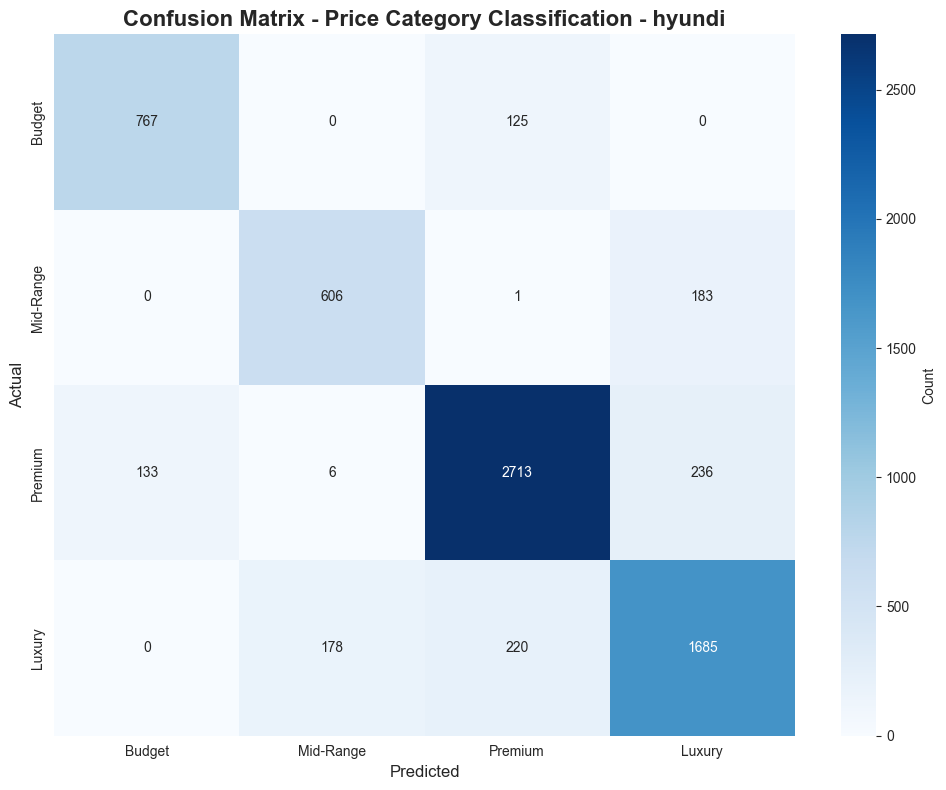

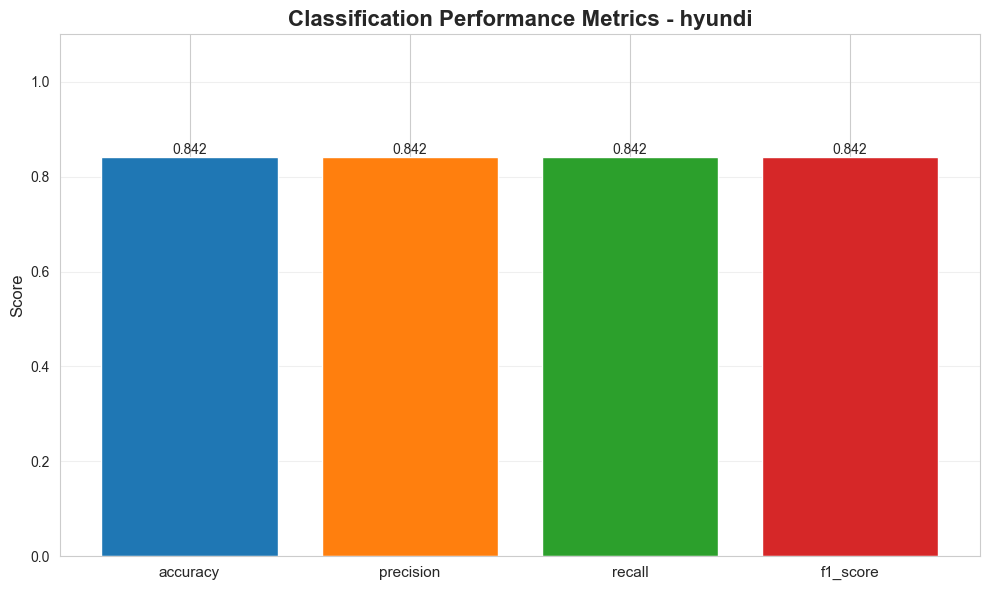

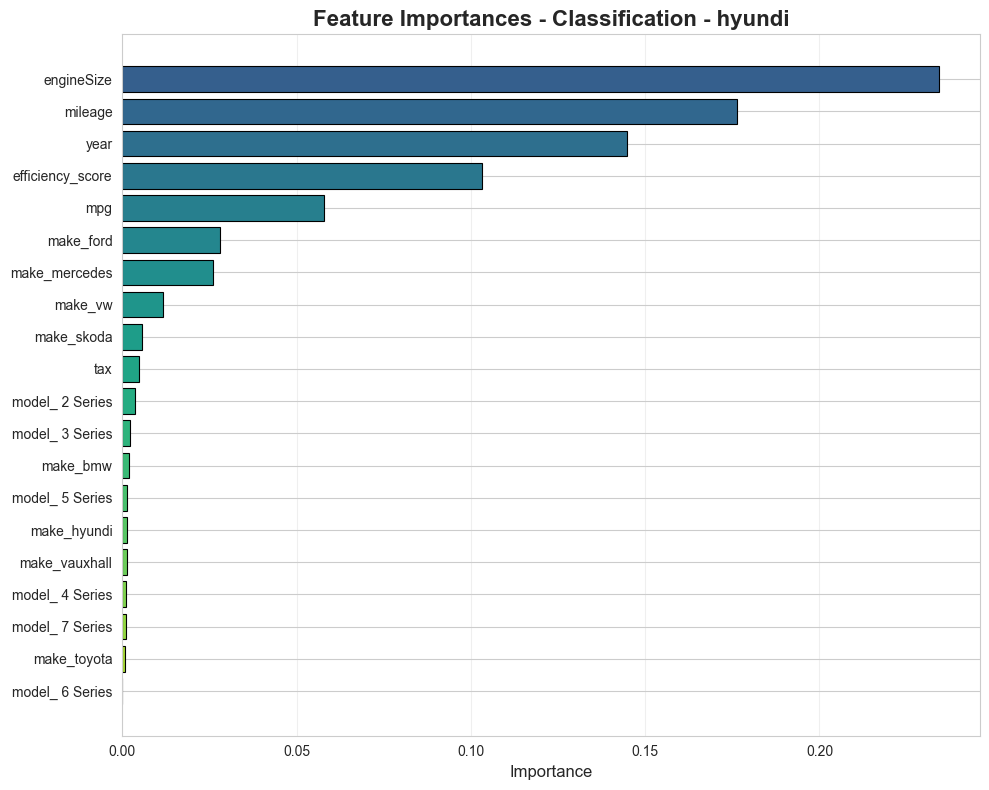

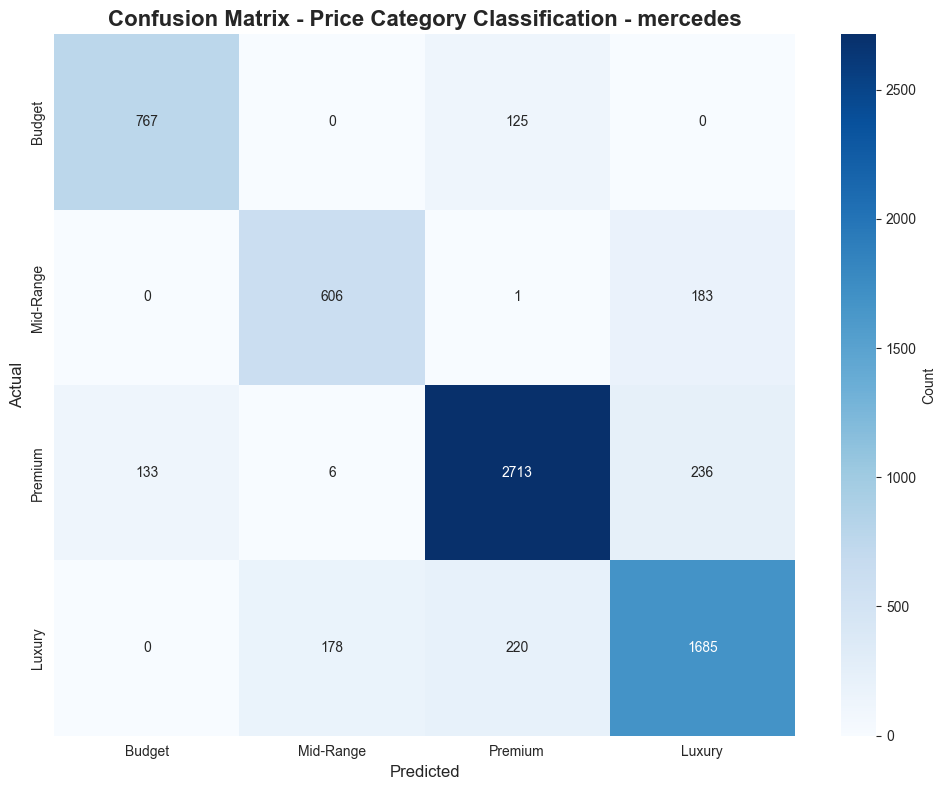

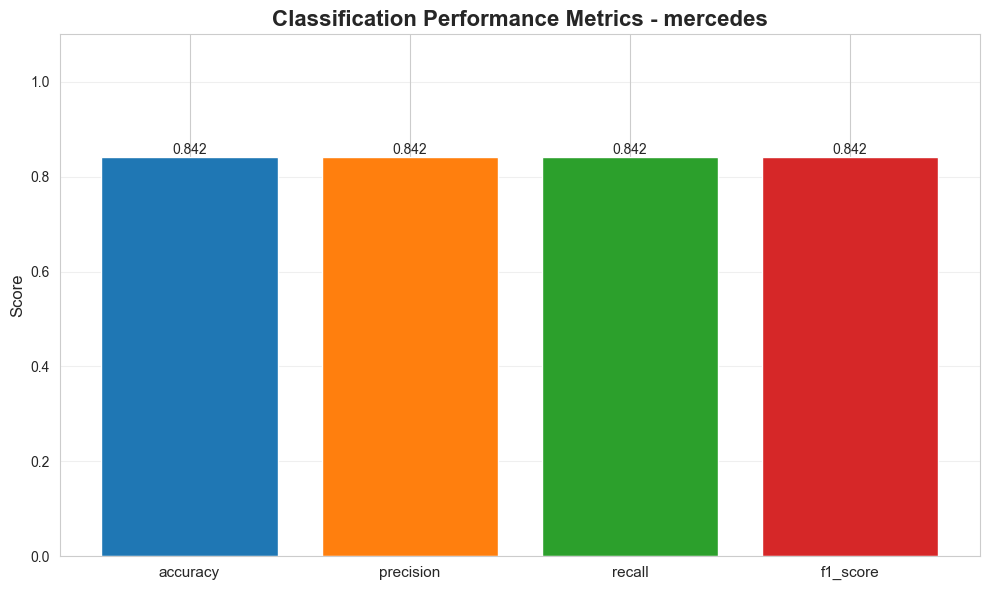

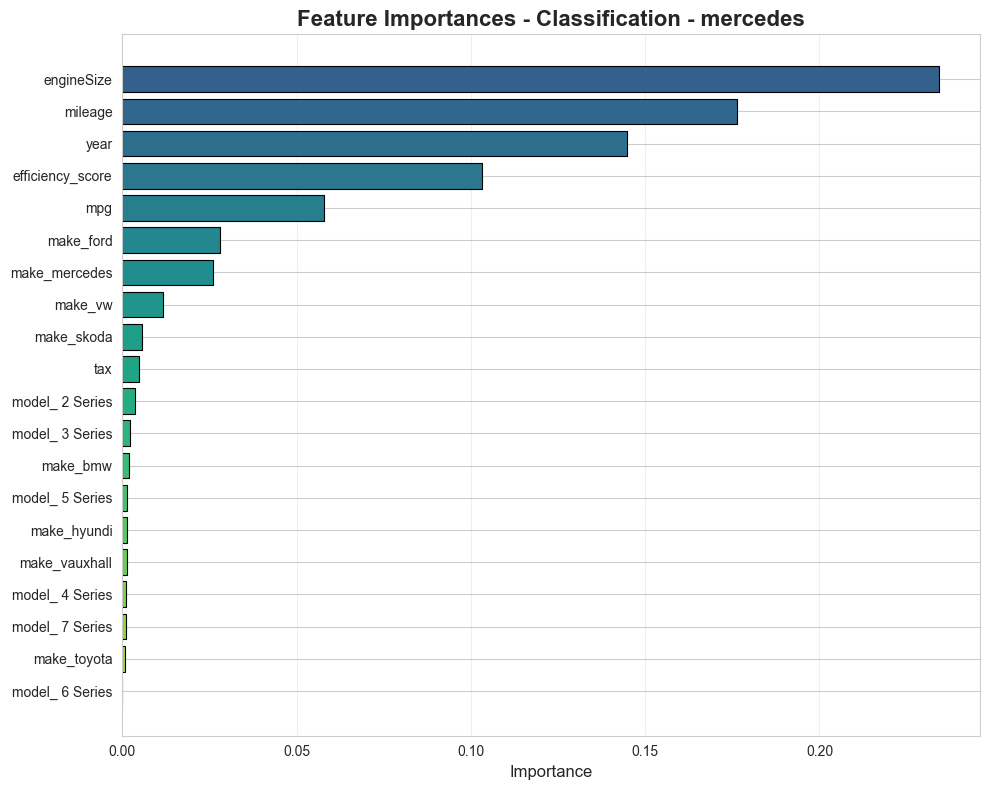

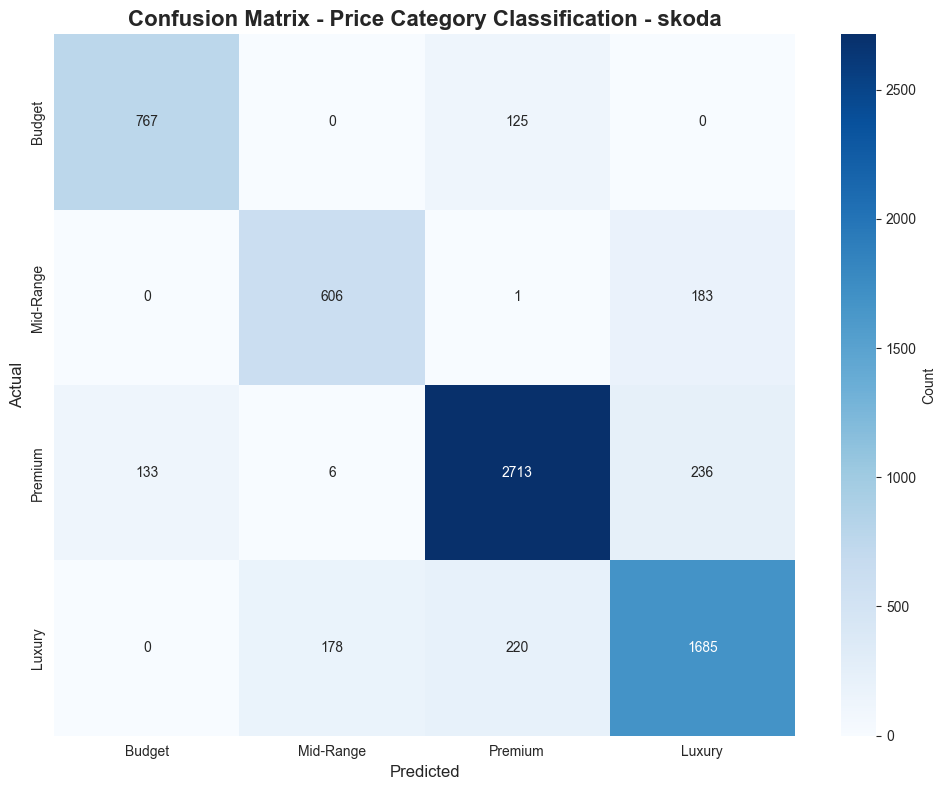

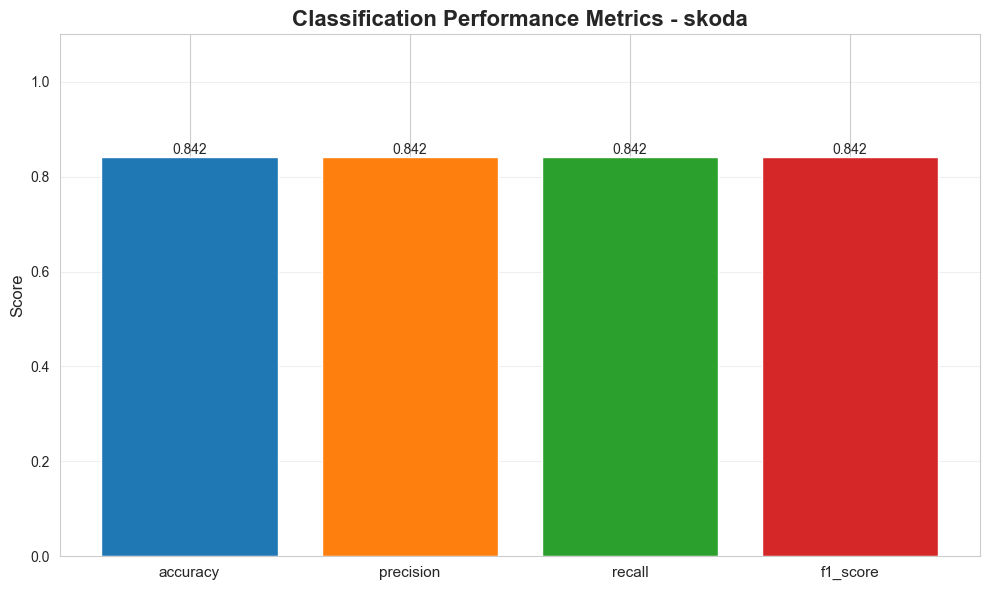

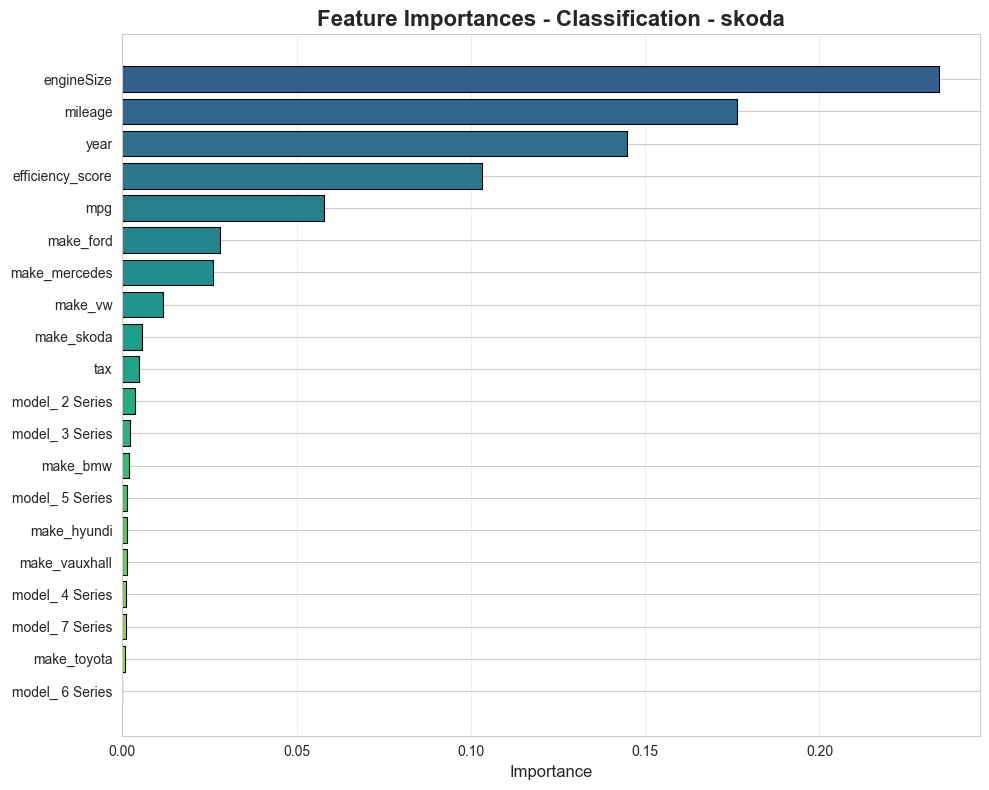

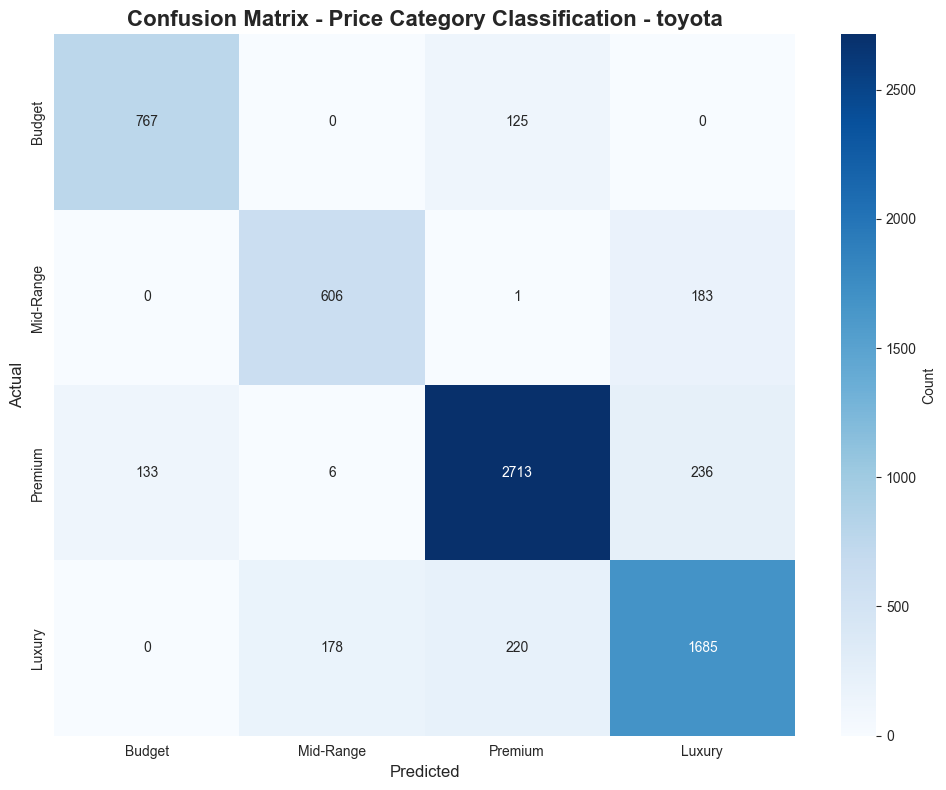

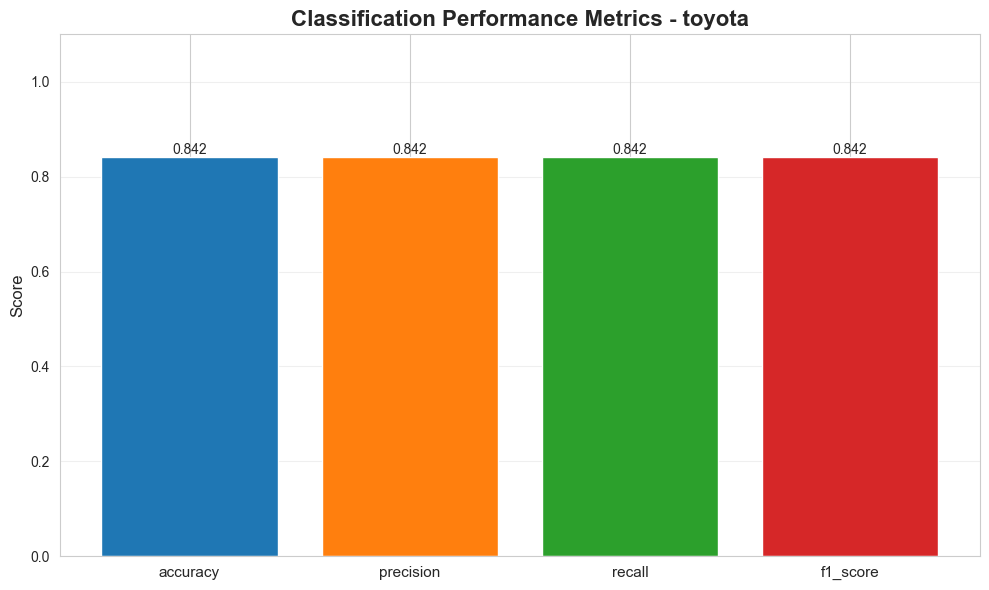

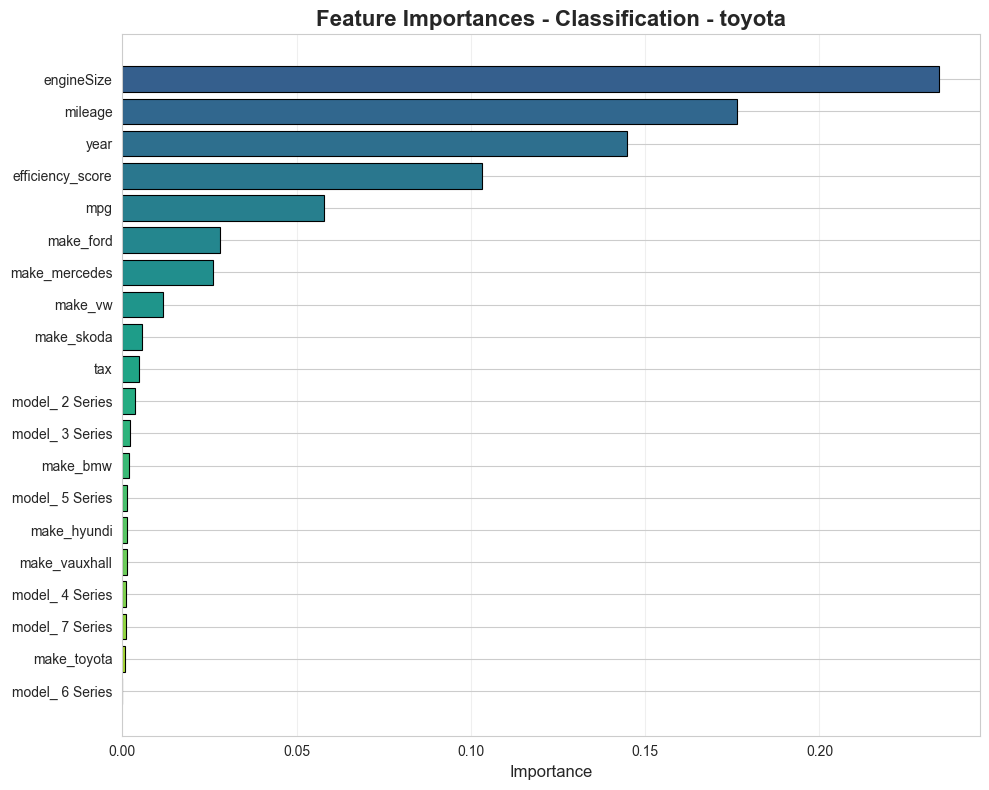

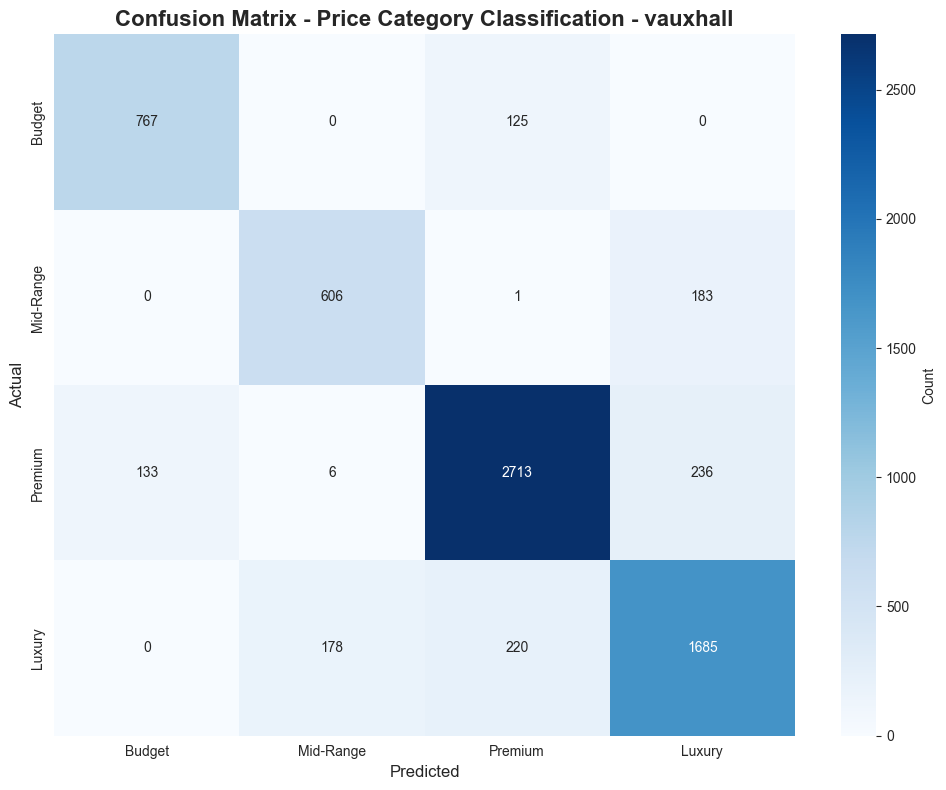

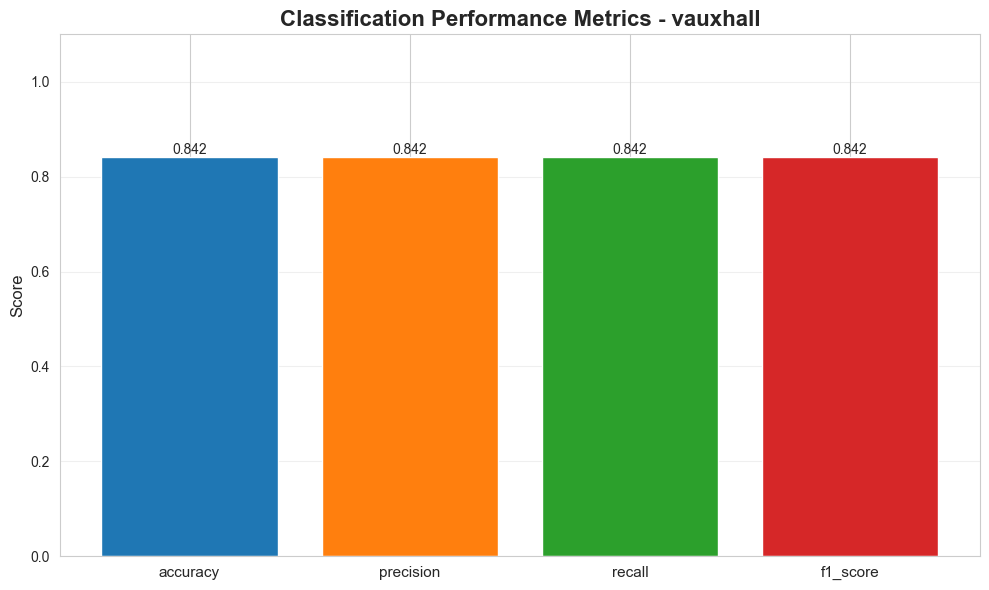

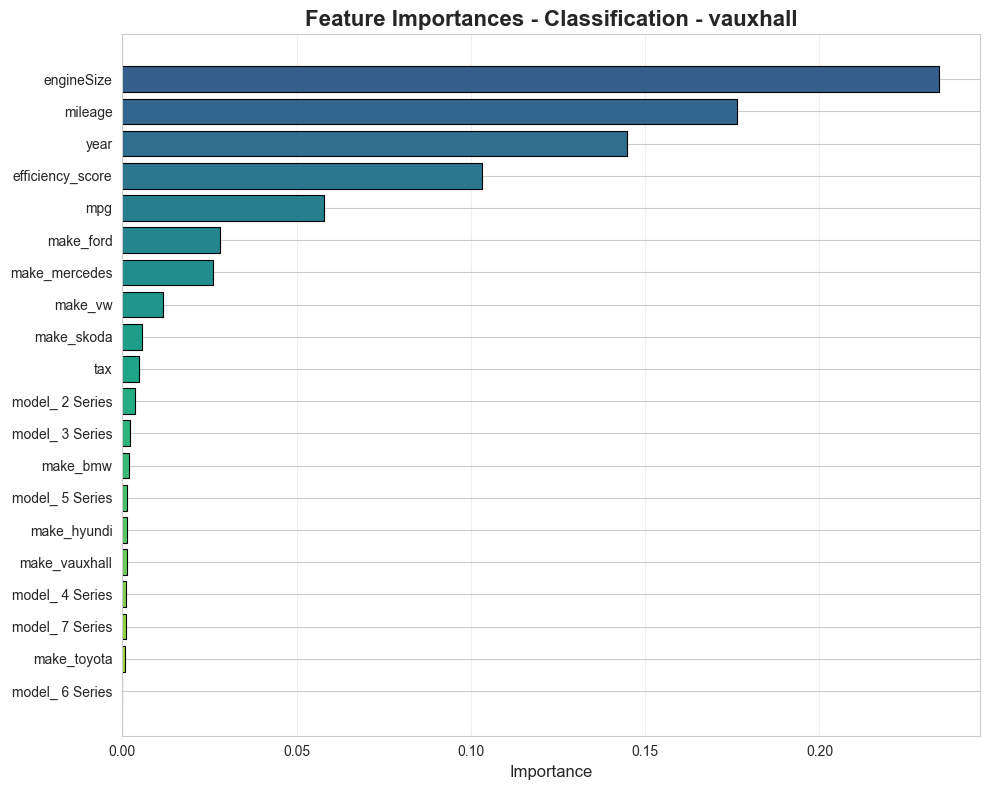

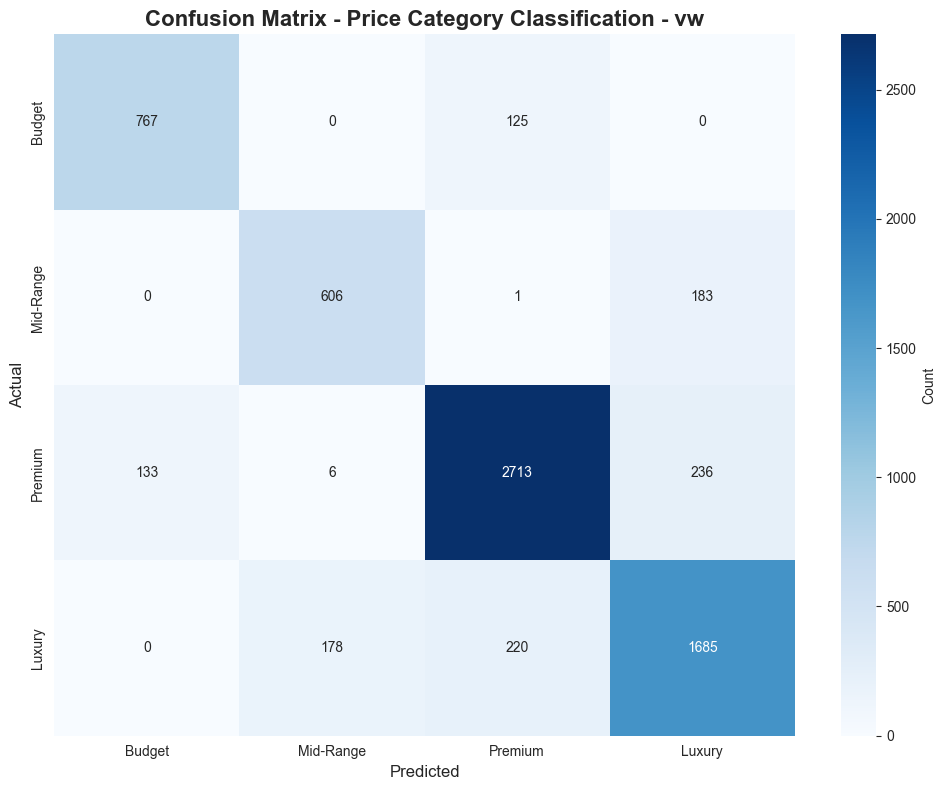

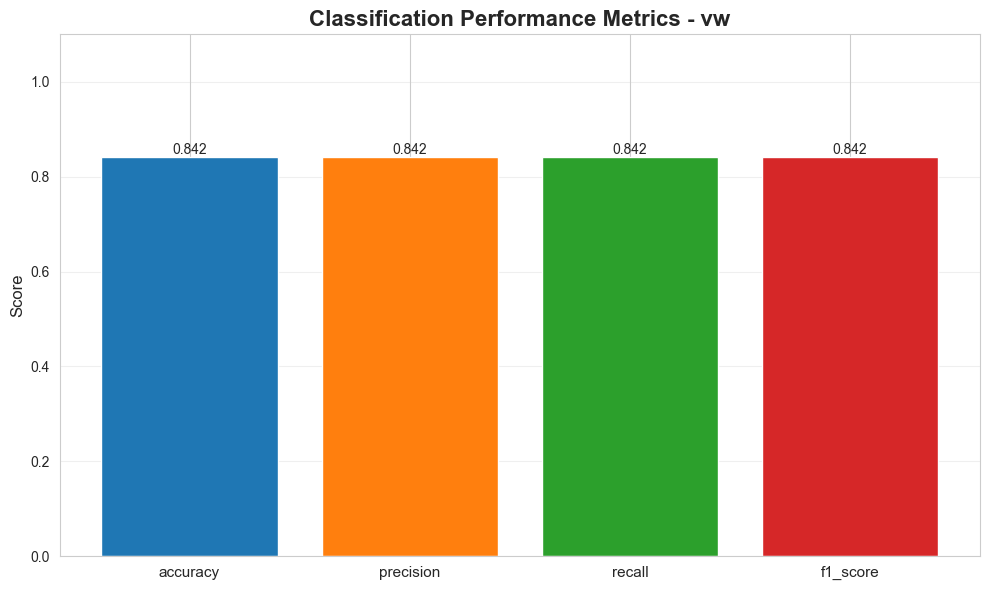

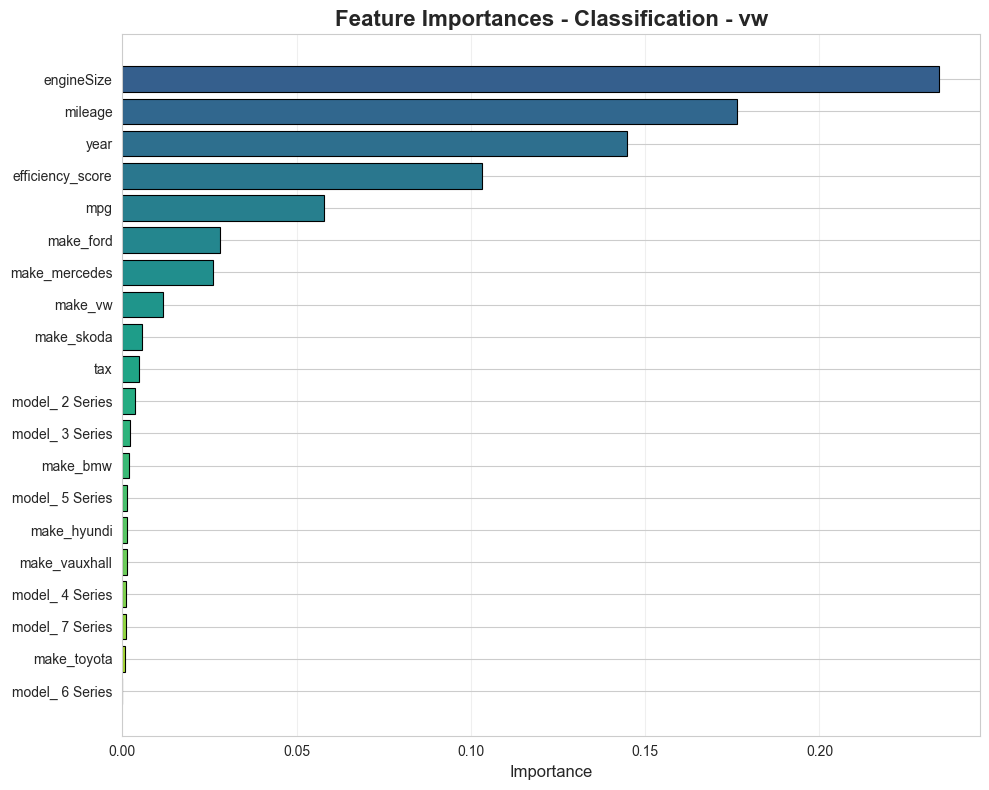

In [9]:
for make_vehicle, data in trained_models_per_make.items():
	model = data["model"]
	y_test = data['y_test']
	feature_names = data["feature_names"]
	predictions = data['predictions']
	metrics = classification_metrics(y_test, predictions)

	values, kind = get_feature_effects(model)

	n = model.n_features_in_
	feature_names = feature_names[:n]
	values = values[:n]

	plot_confusion_matrix(
		y_test, 
		predictions,
		labels=['Budget', 'Mid-Range', 'Premium', 'Luxury'],
		title=f"Confusion Matrix - Price Category Classification - {make_vehicle}"
	)

	# Classification metrics bar chart
	plot_classification_metrics(
		metrics,
		title=f"Classification Performance Metrics - {make_vehicle}"
	)

	# Feature importances for classification
	values_class, kind_class = get_feature_effects(model)
	plot_feature_importances(
		values_class[:20],
		feature_names[:20],
		f"Feature {kind_class.title()}s - Classification - {make_vehicle}"
	)